<a href="https://colab.research.google.com/github/nicole-whitlock/games/blob/main/Distilbert_Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import re
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tf_keras.callbacks import EarlyStopping
import joblib


from transformers import   TFDistilBertModel, TFDistilBertForSequenceClassification, DistilBertTokenizer
from transformers.optimization_tf import AdamWeightDecay
from tf_keras.callbacks import EarlyStopping

In [2]:
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

### The dataset was previously filtered for english speech quotes and the appropriate labels were kept. Loading the filtered dataset to work with the Distilbert model.

In [3]:
df = pd.read_csv('/content/english_reviews.csv')

In [4]:
df.head()

,id,title,quote,score,date,platform,author,publicationName,review_type
0,1300001290,The Legend of Zelda: Ocarina of Time,"an open world on the classic console, perhaps ...",100.0,2023-02-03,Nintendo 64,aaronnmp96,NaN,user
1,1300001290,The Legend of Zelda: Ocarina of Time,This masterpiece holds a special place in the ...,100.0,2022-10-24,Nintendo 64,AmadouIraklidis,NaN,user
2,1300001290,The Legend of Zelda: Ocarina of Time,10 out of 10 easily one of the best games of h...,100.0,2023-01-31,Nintendo 64,slushy,NaN,user
3,1300001290,The Legend of Zelda: Ocarina of Time,Absolutely the best game ever made. Completely...,100.0,2022-06-12,Nintendo 64,Konnor1224,NaN,user
4,1300001290,The Legend of Zelda: Ocarina of Time,the people rating this game a 0 will absolutel...,100.0,2022-11-21,Nintendo 64,Pokemandeluxe,NaN,user


Creating sentiment column to group scores into sentiment

In [5]:
# Create 3 sentiment categories
df['sentiment'] = np.where(
    df['score'] >= 70, 'positive',
    np.where(df['score'] <= 40, 'negative', 'neutral')
)

Select random subset of 50000 samples

In [6]:
df = df.sample(n=50000)

Minimal data cleaning to remove extra whitespaces for the distilbert pretrained model was performed.

In [7]:
def clean_whitespace(text):
    # Remove leading/trailing spaces and collapse multiple spaces into one
    return re.sub(r'\s+', ' ', text.strip())

df['quote'] = df['quote'].apply(clean_whitespace)

In [8]:
data_quotes = df['quote'].tolist()
data_sentiments = df['sentiment'].tolist()

train_quotes, test_quotes, train_scores, test_scores = train_test_split(
    data_quotes, data_sentiments, test_size= 0.2, random_state = 42,
    stratify = data_sentiments)

train_quotes, val_quotes, train_scores, val_scores = train_test_split(
    train_quotes, train_scores, test_size = 0.15, random_state = 42
    )


In [9]:
tokenizer = DistilBertTokenizer.from_pretrained(
    'distilbert-base-uncased',
    cache_dir=None,
    force_download=True
)

model = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3,
    from_pt=True,
    cache_dir=None,
    force_download=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla

Function to tokenize the dataset using distilbert tokenizer. Processing in batches to avoid crashing memory

In [10]:
def prepare_chunked_tf_dataset(texts, labels, tokenizer, max_length=64, batch_size=32, chunk_size=5000):

    dataset = None



    # Process in chunks
    for i in range(0, len(texts), chunk_size):
        end_idx = min(i + chunk_size, len(texts))
        chunk_texts = texts[i:end_idx]
        chunk_labels = labels[i:end_idx]

        # Tokenize this chunk
        encodings = tokenizer(
            chunk_texts,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='tf'
        )

        label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}  # Define the mapping
        chunk_labels = [label_mapping[label] for label in chunk_labels]  # Apply the mapping

        # Create dataset for this chunk
        chunk_dataset = tf.data.Dataset.from_tensor_slices((
            dict(encodings),
            chunk_labels
        ))

        # Add to main dataset
        if dataset is None:
            dataset = chunk_dataset
        else:
            dataset = dataset.concatenate(chunk_dataset)

        print(f"Processed {end_idx}/{len(texts)} examples")

        # Clear memory
        del chunk_texts, chunk_labels, encodings, chunk_dataset
        import gc
        gc.collect()

    # Apply batching and prefetching to the combined dataset
    return dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)



Preparing train/test/validation datasets

In [11]:
train_dataset = prepare_chunked_tf_dataset(train_quotes, train_scores, tokenizer)
val_dataset = prepare_chunked_tf_dataset(val_quotes, val_scores, tokenizer)
test_dataset = prepare_chunked_tf_dataset(test_quotes, test_scores, tokenizer)

Processed 5000/34000 examples
Processed 10000/34000 examples
Processed 15000/34000 examples
Processed 20000/34000 examples
Processed 25000/34000 examples
Processed 30000/34000 examples
Processed 34000/34000 examples
Processed 5000/6000 examples
Processed 6000/6000 examples
Processed 5000/10000 examples
Processed 10000/10000 examples


In [12]:
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)


# Compile the model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Train
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stopping]
)


Epoch 1/10
1063/1063 [==============================] - 53s 38ms/step - loss: 0.5151 - accuracy: 0.7976 - val_loss: 0.4746 - val_accuracy: 0.8152
Epoch 2/10
1063/1063 [==============================] - 38s 36ms/step - loss: 0.3619 - accuracy: 0.8614 - val_loss: 0.4907 - val_accuracy: 0.8142
Epoch 3/10
1063/1063 [==============================] - 38s 36ms/step - loss: 0.2451 - accuracy: 0.9103 - val_loss: 0.5742 - val_accuracy: 0.8048


In [23]:
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred.logits, axis=1)


313/313 [==============================] - 4s 13ms/step


In [27]:
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
test_scores_numerical = [label_mapping[label] for label in test_scores]

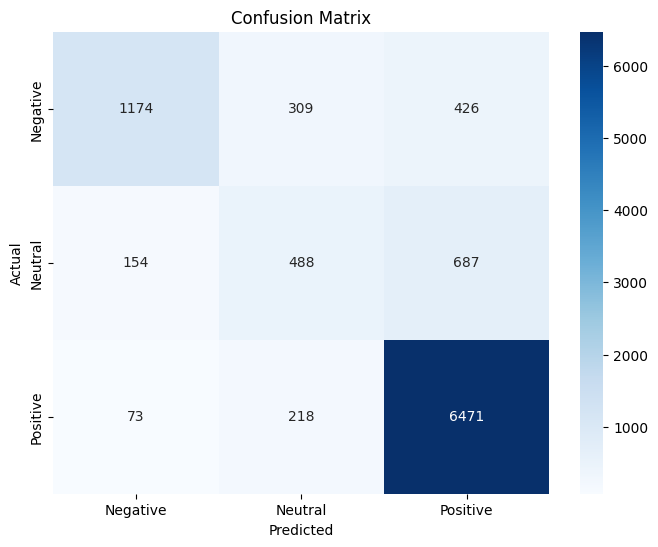

In [32]:
plt.figure(figsize=(8,6))
cm = confusion_matrix(test_scores_numerical, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [31]:
plt.figure(figsize=(8,6))
cm = confusion_matrix(test_scores_numerical, y_pred_classes)


<Figure size 800x600 with 0 Axes>

In [35]:
joblib.dump(model, 'distilbert_sentiment_model.pkl')
joblib.dump(tokenizer, 'distilbert_tokenizer.pkl')
print("\nSaved model and vectorizer")

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)



Saved model and vectorizer
